In [1]:
import sys
import os
from PIL import Image
import IPython.display as display
from IPython.display import clear_output
sys.path.append(os.path.abspath("ZeroNVS"))
from zero123gen import Zero123Generator

In [2]:
device = "cuda"
config_path = "ZeroNVS/zeronvs_config.yaml"
ckpt_path = "ZeroNVS/zeronvs.ckpt"
precomputed_scale = 1.0

In [3]:
generator = Zero123Generator(config_path, ckpt_path, device, precomputed_scale, dont_eval=True)

/home/gp/.local/lib/python3.10/site-packages/torch/__init__.py:1117: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
/home/gp/sleeperagent/ZeroNVS/zeronvs_diffusion/zero123/ldm/models/diffusion/ddpm.py:145: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  hasattr(obj, "data") and torch.is_tensor(obj.data)


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.53 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [4]:
import torch
import torch.nn as nn

class LoRALinear(nn.Module):
    def __init__(self, base_layer, r=4, alpha=1.0):
        super().__init__()
        self.base = base_layer
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r

        self.lora_A = nn.Linear(base_layer.in_features, r, bias=False)
        self.lora_B = nn.Linear(r, base_layer.out_features, bias=False)
        nn.init.zeros_(self.lora_B.weight)

    def forward(self, x):
        return self.base(x) + self.scaling * self.lora_B(self.lora_A(x))

In [5]:
def inject_lora_crossattn(model, r=4, alpha=1.0):
    from ldm.modules.attention import CrossAttention, BasicTransformerBlock

    def wrap_lora(module, name):
        orig = getattr(module, name)
        if not isinstance(orig, LoRALinear):
            setattr(module, name, LoRALinear(orig, r=r, alpha=alpha))

    model = model.model.diffusion_model  # UNetModel

    for name, module in model.named_modules():
        # if isinstance(module, CrossAttention) and ".attn2" in name:
        # if isinstance(module, CrossAttention):
        if isinstance(module, BasicTransformerBlock):
            ca = module.attn2
            wrap_lora(ca, "to_q")
            wrap_lora(ca, "to_k")
            wrap_lora(ca, "to_v")
            #Disable checkpointing
            module.checkpoint = False  

#Inject it only in certain blocks and disable checkpointing for that
            #Does not work well
# def inject_lora_crossattn(model, r=4, alpha=1.0, target_block_ids=range(10, 16)):
#     from ldm.modules.attention import CrossAttention, BasicTransformerBlock

#     def wrap_lora(module, name):
#         orig = getattr(module, name)
#         if not isinstance(orig, LoRALinear):
#             setattr(module, name, LoRALinear(orig, r=r, alpha=alpha))

#     model = model.model.diffusion_model  # UNetModel
#     block_idx = 0

#     for name, module in model.named_modules():
#         if isinstance(module, BasicTransformerBlock):
#             if "input_block" in name:
#                 ca = module.attn2
#                 wrap_lora(ca, "to_q")
#                 wrap_lora(ca, "to_k")
#                 wrap_lora(ca, "to_v")
#                 module.checkpoint = False  
#             block_idx += 1

In [6]:
def freeze_except_lora(model):
    for name, param in model.named_parameters():
        if "lora_" in name.lower():
            param.requires_grad = True
        else:
            param.requires_grad = False

In [7]:
def print_trainable_layers(model):
    print("Trainable parameters list:\n")
    total_trainable_parameters = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_trainable_parameters += param.numel()
            print(f"{name} | shape: {tuple(param.shape)}")
    print(f"Total trainable parameters: {total_trainable_parameters}")

In [8]:
#Add LoRA layers to the crossattention layers specifically in diffusion model
#If full generator.model is used, it will apply it to other parts of the model too
inject_lora_crossattn(generator.model)

#Now move model to cuda and eval
generator.model = generator.model.to(device).eval()

#Freeze all layers except LoRA layers
freeze_except_lora(generator.model)

#Just print the modules which has checkpoint enabled or disabled for sanity check: Should be false everywhere
#Note that if checkpoint for downstream is on the gradients cannot feed backwards to the middle LoRA layers
for module in generator.model.model.diffusion_model.modules():
    if hasattr(module, 'checkpoint'):
        print(module.checkpoint)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [9]:
#Print trainable params
# print_trainable_layers(generator.model)

In [10]:
import torch.nn.functional as F
from tqdm import tqdm

def train_ldm_latent_regression(generator, dataloader, optimizer, device="cuda", epochs=10, ddim_steps=10, scale=7.5):
    model = generator.model
    scheduler = generator.scheduler
    scheduler.set_timesteps(ddim_steps)
    lambda_img = 0.7
    model.train()
    for epoch in range(epochs):
        tot_loss = 0
        num_batches = 0
        for batch in tqdm(dataloader):
            num_batches += 1
            # Prepare conditioning
            cond = batch["cond"]
            cond["c_crossattn"][0] = cond["c_crossattn"][0].flatten(0, 1).detach().to(device)
            cond["c_concat"][0] = cond["c_concat"][0].flatten(0, 1).detach().to(device)
            z_target = batch["z_target"].detach().to(device)
            
            B = z_target.shape[0]

            # Start from Gaussian noise
            latents = torch.randn_like(z_target)

            # Denoise using same logic as inference (no guidance)
            for t in scheduler.timesteps:
                x_in = torch.cat([latents] * 2)
                t_in = torch.cat([t.reshape(1).repeat(B)] * 2).to(device)
                noise_pred = model.apply_model(x_in, t_in, cond)
                noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2) 
                # noise_pred = noise_pred_uncond + scale * (noise_pred_cond - noise_pred_uncond)
                noise_pred = noise_pred_cond
                latents = scheduler.step(noise_pred, t, latents)["prev_sample"]
            # Regression loss between final denoised latent and target latent
            loss_latent = F.mse_loss(latents, z_target)
            
            with torch.no_grad():
                #Another loss for pixel level update
                x_target = model.decode_first_stage(z_target).clamp(-1, 1)
            x_pred = model.decode_first_stage(latents).clamp(-1, 1)
            loss_image = F.mse_loss(x_pred, x_target)
            
            loss = loss_latent + lambda_img * loss_image
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tot_loss += loss

        print(f"Epoch {epoch}: Loss = {tot_loss.item()/num_batches:.4f}")

In [11]:
import math

def generate_camera_pose(elv, azm, cam_dist):
    elv = torch.FloatTensor([elv]) * math.pi / 180
    azm = torch.FloatTensor([azm]) * math.pi / 180
    cam_pos: Float[Tensor, "1 3"] = torch.stack(
        [
            cam_dist * torch.cos(elv) * torch.cos(azm),
            cam_dist * torch.cos(elv) * torch.sin(azm),
            cam_dist * torch.sin(elv),
        ],
        dim=-1,
    )
    center: Float[Tensor, "1 3"] = torch.zeros_like(cam_pos)
    up: Float[Tensor, "1 3"] = torch.as_tensor([0, 0, 1], dtype=torch.float32)[
        None
    ]
    lookat: Float[Tensor, "1 3"] = F.normalize(center - cam_pos, dim=-1)
    right: Float[Tensor, "1 3"] = F.normalize(torch.cross(lookat, up, dim=-1), dim=-1)
    up = F.normalize(torch.cross(right, lookat, dim=-1), dim=-1)
    c2w_3x4: Float[Tensor, "1 3 4"] = torch.cat(
        [
            torch.stack([right, up, -lookat], dim=-1),
            cam_pos[:, :, None],
        ],
        dim=-1,
    )
    bottom_row = torch.tensor([0, 0, 0, 1], dtype=torch.float32).view(1, 1, 4)
    c2w = torch.cat([c2w_3x4, bottom_row], dim=1)
    return c2w

In [14]:
#Load files
import numpy as np
orig_images = []
orig_elevations = []
orig_azimuths = []
orig_cam_dists = []

ref_images = []
# ref_elevations = 
# ref_azimuths = [60]*4
# ref_cam_dists = [10]*4
for env_id in range(10):
    for frame_count in range(100): #Just using first 100 frames
        filename = f"data/run_{env_id}_{frame_count}_orig_img.npy"
        with open(filename, 'rb') as f:
            orig_images.append(torch.from_numpy(np.load(f)).to(device))
        filename = f"data/run_{env_id}_{frame_count}_orig_elevations.npy"
        with open(filename, 'rb') as f:
            orig_elevations.append(np.load(f).item())
        filename = f"data/run_{env_id}_{frame_count}_orig_azimuths.npy"
        with open(filename, 'rb') as f:
            orig_azimuths.append(np.load(f).item())
        filename = f"data/run_{env_id}_{frame_count}_orig_cam_dists.npy"
        with open(filename, 'rb') as f:
            orig_cam_dists.append(np.load(f).item())
        filename = f"data/run_{env_id}_{frame_count}_ref_img.npy"
        with open(filename, 'rb') as f:
            ref_images.append(torch.from_numpy(np.load(f)).to(device))
    

In [15]:
ref_elevations = [45]*len(ref_images)
ref_azimuths = [170]*len(ref_images)
ref_cam_dists = [1.2]*len(ref_images)

In [16]:
#Create Dataset
#Collect original and reference images, original and reference camera elevation and azimuth
dataset = []
fovy = torch.deg2rad(torch.FloatTensor([60]))
for orig_img, orig_elv, orig_azm, orig_cam_dist, ref_img, ref_elv, ref_azm, ref_cam_dist in tqdm(zip(orig_images, orig_elevations, orig_azimuths, orig_cam_dists, ref_images, ref_elevations, ref_azimuths, ref_cam_dists)):
    orig_c_crossattn, orig_c_concat = generator.encode_image(orig_img) 
    orig_c2w = generate_camera_pose(orig_elv, orig_azm, orig_cam_dist)
    _, ref_c_concat = generator.encode_image(ref_img)
    ref_c2w = generate_camera_pose(ref_elv, ref_azm, ref_cam_dist)
    #Immediately generate conditioning
    cond = generator.make_condition(orig_c_crossattn.squeeze(0).detach(), orig_c_concat.squeeze(0).detach(), ref_c2w.detach(), orig_c2w.detach(), fovy.detach())
    data = {}
    # cond["c_concat"][0] = cond["c_concat"][0].to("cpu")
    # cond["c_crossattn"][0] = cond["c_crossattn"][0].to("cpu")
    data["cond"] = cond
    data["z_target"] = ref_c_concat.squeeze(0).detach()
    dataset.append(data)

1000it [00:30, 32.82it/s]


In [17]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [18]:
#Set up optimizer
from torch.optim import AdamW
optimizer = AdamW(
    filter(lambda p: p.requires_grad, generator.model.parameters()),
    # generator.model.parameters(),
    lr=1e-5,
    weight_decay=0.01
)

In [ ]:
train_ldm_latent_regression(generator, dataloader, optimizer, device="cuda", epochs=50, ddim_steps=10)

100%|███████████████████████████████████████| 1000/1000 [07:59<00:00,  2.09it/s]


Epoch 0: Loss = 51.5078


100%|███████████████████████████████████████| 1000/1000 [08:01<00:00,  2.08it/s]


Epoch 1: Loss = 47.1570


100%|███████████████████████████████████████| 1000/1000 [08:01<00:00,  2.08it/s]


Epoch 2: Loss = 40.4591


 11%|████▍                                   | 111/1000 [00:53<07:07,  2.08it/s]

Input


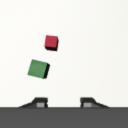

Ref


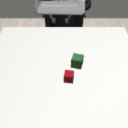

tensor(8.2660, device='cuda:0', grad_fn=<MseLossBackward0>)
Output


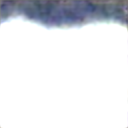

In [30]:
#Test
import cv2
# image = generator.get_image(image_path)
img_id = 0
print("Input")
imm = orig_images[img_id]
imm = (imm * 0.5 + 0.5).clamp(0, 1).to(torch.float32).detach().cpu().numpy().transpose(0, 2, 3, 1)
resized_image = cv2.resize(imm.squeeze(0), (128, 128))
resized_image = (resized_image*255).astype(np.uint8)
display.display(Image.fromarray(resized_image))
print("Ref")
imm = ref_images[img_id]
imm = (imm * 0.5 + 0.5).clamp(0, 1).to(torch.float32).detach().cpu().numpy().transpose(0, 2, 3, 1)
resized_image = cv2.resize(imm.squeeze(0), (128, 128))
resized_image = (resized_image*255).astype(np.uint8)
display.display(Image.fromarray(resized_image))

#Generate image
batch = dataset[img_id]
cond = batch["cond"]
#Changes to conditioning
cond["c_crossattn"][0] = cond["c_crossattn"][0].detach().to(device)
cond["c_concat"][0] = cond["c_concat"][0].detach().to(device)
#Obtain target_latent
z_target = batch["z_target"].detach().to(device)
B = cond["c_crossattn"][0].shape[0] // 2
latents = torch.randn((B, 4, 32, 32), device=device)
generator.scheduler.set_timesteps(10)
for t in generator.scheduler.timesteps:
    x_in = torch.cat([latents] * 2)
    t_in = torch.cat([t.reshape(1).repeat(B)] * 2).to(device)
    noise_pred = generator.model.apply_model(x_in, t_in, cond)
    noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
    # noise_pred = noise_pred_uncond + 5 * (noise_pred_cond - noise_pred_uncond)
    #I trained only on conditioned inputs
    noise_pred = noise_pred_cond
    latents = generator.scheduler.step(noise_pred, t, latents)["prev_sample"]
print(F.mse_loss(latents.squeeze(0), z_target))
# latents = generator.generate_latents(orig_images[img_id], gen_azm=[170], gen_elv=10, gen_camera_distance=1.2, default_elv=orig_elevations[img_id], default_azm=orig_azimuths[img_id], default_camera_distance=orig_cam_dists[img_id], scale=7.5, ddim_steps=10)
images = generator.decode_latents(latents)
print("Output")
for im in images:
    display.display(Image.fromarray(im))

In [ ]:
generator.model.num_timesteps = 10

In [ ]:
generator.model.num_timesteps

In [ ]:
batch = dataset[1]
cond = batch["cond"]
print(cond["c_crossattn"][0].shape)
#Changes to conditioning
cond["c_crossattn"][0] = cond["c_crossattn"][0].flatten(0,1).detach().to(device)
cond["c_concat"][0] = cond["c_concat"][0].flatten(0,1).detach().to(device)
#Obtain target_latent
z_target = batch["z_target"].detach().to(device)

In [ ]:
cond["c_concat"][0].shape

In [ ]:
np.mean(np.square(im.flatten(),resized_image.flatten()))

In [ ]:
torch.save(generator.model.state_dict(), "ZeroNVS/finetuned2_zeronvs.ckpt")

In [ ]:
del generator

In [ ]:
del dataset

In [ ]:
print(torch.cuda.memory_summary(device="cuda"))